# Dask imaging demonstration

This notebook explores the use of dask for parallelisation. We work through the steps of imaging, generating graphs, ending up with a major/minor cycle algorithm using dask.

In [1]:
%matplotlib inline

import os
import sys

from distributed import Client, progress
from dask import delayed
import dask

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.operations import create_visibility, create_visibility_from_rows, \
    copy_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter, vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, \
    create_image_from_visibility, predict_skycomponent_visibility, residual_image, \
    invert_timeslice_single, invert_timeslice_single, \
    predict_timeslice_single, predict_timeslice_single, advise_wide_field

from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, \
    create_image_from_visibility, \
    predict_skycomponent_visibility, residual_image, invert_timeslice_single, \
    predict_timeslice_single, advise_wide_field

from arl.pipelines.dask_graphs import *
from arl.pipelines.generic_dask_graphs import *

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

We create the visibility. 

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')
times = numpy.linspace(-3,+3,13) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e7])


reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame("stokesI"))

create_visibility: 178035 rows, 0.017 GB


Create a grid of components and predict each in turn, using the full phase term including w.

In [3]:
npixel = 512
cellsize=0.001
flux = numpy.array([[100.0]])
facets = 4

model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, npol=1,
                                    polarisation_frame=PolarisationFrame("stokesI"))
spacing_pixels = npixel // facets
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
comps = list()
for iy in centers:
    for ix in centers:
        pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
        pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comps.append(create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                         polarisation_frame=PolarisationFrame("stokesI")))
vt = predict_skycomponent_visibility(vt, comps)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 10000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 128
Component at (63.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 34.4144013, -54.71664839)>
Component at (191.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.55800518, -55.91819473)>
Component at (319.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 8.44199482, -55.91819473)>
Component at (447.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 355.5855987, -54.71664839)>
Component at (63.000000, 191.000000) <SkyCoord (ICRS): (ra, dec) in de

In [4]:
model_graph = delayed(create_image_from_visibility)(vt, npixel=512, cellsize=0.001, npol=1)
psf_graph = create_invert_graph(vt, model_graph, dopsf=True, 
                                invert_single=invert_timeslice_single, 
                                iterator=vis_timeslice_iter, 
                                normalize=False, timeslice=10.0)
residual_timeslice_graph = create_residual_graph(vt, model_graph, 
                                                 predict_residual=predict_timeslice_single, 
                                                 invert_residual=invert_timeslice_single, 
                                                 iterator=vis_timeslice_iter)

solution_graph = create_solve_image_graph(vt, model_graph=model_graph, 
                                          invert_residual=invert_timeslice_single, 
                                          predict_residual=predict_timeslice_single, 
                                          iterator=vis_timeslice_iter, algorithm='hogbom',
                                          niter=1000, fractional_threshold=0.1,
                                          threshold=1.0, nmajor=3, gain=0.1)
residual_timeslice_graph = create_residual_graph(vt, solution_graph, 
                                                 predict_residual=predict_timeslice_single, 
                                                 invert_residual=invert_timeslice_single, 
                                                 iterator=vis_timeslice_iter)


restore_graph = create_restore_graph(solution_graph, psf_graph, residual_timeslice_graph)
restore_graph.visualize()

Create a Client to talk to a scheduler (automatically created) and a number of workers.

In [5]:
c=Client()
c.scheduler_info()

{'address': 'tcp://127.0.0.1:54655',
 'id': 'fd091ec6-333b-11e7-9ac6-a0999b0524c5',
 'services': {'bokeh': 8787},
 'type': 'Scheduler',
 'workers': {'tcp://127.0.0.1:54663': {'host': '127.0.0.1',
   'last-seen': 1494171844.6355479,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nanny-wppqrmgw',
   'memory_limit': 1288490188.0,
   'name': 'tcp://127.0.0.1:54663',
   'ncores': 1,
   'services': {'bokeh': 54664, 'nanny': 54656},
   'time-delay': 0.16552424430847168},
  'tcp://127.0.0.1:54665': {'host': '127.0.0.1',
   'last-seen': 1494171844.660107,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/nanny-9sg81x3t',
   'memory_limit': 1288490188.0,
   'name': 'tcp://127.0.0.1:54665',
   'ncores': 1,
   'services': {'bokeh': 54669, 'nanny': 54659},
   'time-delay': 0.0046918392181396484},
  'tcp://127.0.0.1:54668': {'host': '127.0.0.1',
   'last-seen': 1494171844.665441,
   'local_directory': '/var/folders/hw/kw6kvgqs7mn49ldhmr4wcfch0000gn/T/na

Now we can use the client to execute the graph.

In [7]:
future=c.compute(restore_graph);progress(future)

future.result will wait until the result is ready

In [8]:
restored_image=future.result()

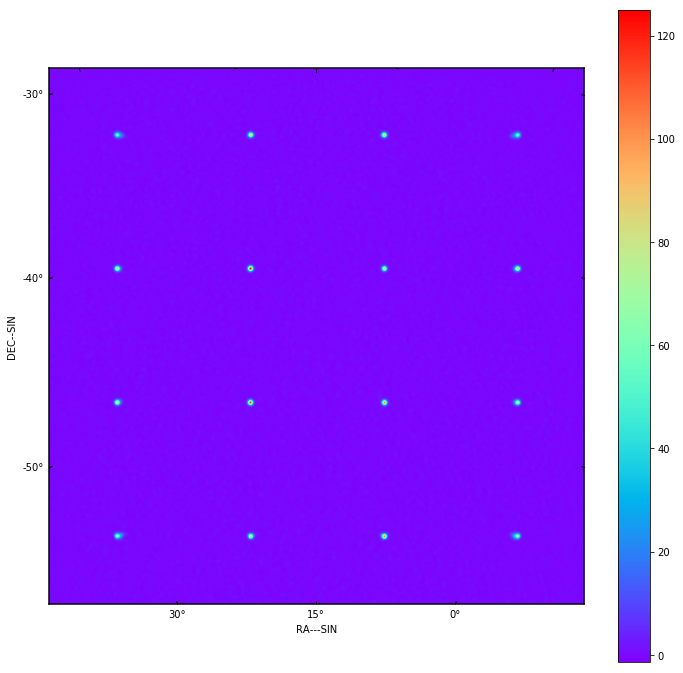

In [9]:
show_image(restored_image)
plt.show()

In [10]:
c.shutdown()

/Users/timcornwell/arlenv/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))


In [11]:
restored_image.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 15.0  -45.0  1.0  100000000.0  
CRPIX : 256.0  256.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.057295779513081999  0.057295779513081999  1.0  10000000.0  
NAXIS : 0  0

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x126f86950>, <tornado.concurrent.Future object at 0x120da4d30>)
Traceback (most recent call last):
  File "/Users/timcornwell/arlenv/lib/python3.6/site-packages/distributed/comm/core.py", line 159, in connect
    quiet_exceptions=EnvironmentError)
  File "/Users/timcornwell/arlenv/lib/python3.6/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/Users/timcornwell/arlenv/lib/python3.6/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 3, in raise_exc_info
tornado.gen.TimeoutError: Timeout

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/timcornwell/arlenv/lib/python3.6/site-packages/tornado/ioloop.py", line 604, in _run_callback
    ret = callback()
  File "/Users/timcornwell/arlenv/lib/python3.6/site-packages